In [91]:
import os
import sys
import random
import exifread
import piexif
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

import numpy as np
import pandas as pd
import xml.etree.ElementTree as ET

from imp import reload
import classparse; reload(classparse)

<module 'classparse' from '/home/ubuntu/git/deeplearningcourse/elizabeth/data/classparse.py'>

### Adjust to whatever your class labels are. Alternatively, import them in. 

In [5]:
!pwd

/home/ubuntu/git/deeplearningcourse/elizabeth/data


In [23]:
'''
CLASS_LABELS = {
    'none': (0, 'Background'),
    'flower pot': (1, 'Container'),
    'container': (2, 'Container'),
    'porch': (3, 'Cover'),
    'toy': (4, 'Toy'),
    'bucket': (5, 'Container'),
    'basketball': (6, 'Toy'),
    'car': (7, 'Vehicle'),
    'tarp': (8, 'Cover'),
    'gutter': (9, 'Container'),
    'albo property': (10, 'Presence'),
    'no albo property': (11, 'Presence'),
    'trash bin': (12, 'Container'),
    'pot': (13, 'Container'),
    'tarp': (14, 'Container'),
    'table': (15, 'Other'),
    'umbrella': (16, 'Cover'),
    'car': (17, 'Other'),
    'air conditioner': (18, 'Container'),
    'flower bed': (19, 'Other'),
    'drain': (20, 'Other')
}
'''
annopath = '/home/ubuntu/git/deeplearningcourse/elizabeth/data/harrisonweek2/annotations/'
preprocess = classparse.XML_preprocessor(annopath)
CLASS_LABELS = preprocess.classes

In [130]:
annopath = '/home/ubuntu/git/deeplearningcourse/elizabeth/data/images_wks12/annotations/'
photopath = '/home/ubuntu/git/deeplearningcourse/elizabeth/data/images_wks12/images/'
os.chdir(annopath)
!pwd

/home/ubuntu/git/deeplearningcourse/elizabeth/data/images_wks12/annotations


## definitions key for functionality

In [119]:
def deg_rad(inp,key='deg2rad'):
    '''
        Converts degrees to radian or vice versa
        Inp = # to change
        Indicate with key = {deg2rad, rad2deg}
        
        Returns # in radian or degrees, depending on what you specified
        
    '''
    if key=='deg2rad':
        rad = inp*np.pi/180
        return rad
    
    elif key=='rad2deg':
        deg = inp*180/np.pi
        return deg

def len_at_lat(lat):
    
    '''
        Lat = latitude where info is desired
        
        Returns the length in meters of one degree, latitude or longitude, at a specified latitude
        Also returns conversion rate from degrees to meters
        
    '''
    
    #length of 1 degree in meters at a specified latitude
    m_per_lat = 111132.92-559.82*np.cos(2*phi) +1.175*np.cos(4*phi) -0.0023*np.cos(6*phi)
    m_per_lon = 111412.84*np.cos(phi) -93.5*np.cos(3*phi) -0.118*np.cos(5*phi)
    
    #number of seconds per meter
    lat_per_m = 1/m_per_lat
    lon_per_m = 1/m_per_lon
    
    return m_per_lat, m_per_lon, lat_per_m, lon_per_m

def dms2dec(inp):
    
    '''
        Converts inp from degrees, minutes, seconds to decimal
        Expects input to be type Ratio
        Returns converted input
    '''
    
    inp = [float(i.num)/float(i.den) for i in inp]
    inp = inp[0] + (inp[1])/60 + inp[2]/3600
    
    return inp

## Gets a count of each of the instances of the classes, total and # of photos, in tagged photos

In [151]:
#COUNT = {key:[0,0] for key in CLASS_LABELS.keys()}
COUNT = {key:0 for key in CLASS_LABELS}
NEW = {}

def get_counts_of_classes(directory, shape=[512,512]):

    ''' This gets the counts of all the classes in a batch of xml files.
    
        -- Input -- (VOC XML files)
        Directory: directory where annotations (.xml) files are stored.
        Shape: desired shape of photos; WEIRDOS will tell you if it's not that shape.

        -- Returns -- (Dicts)
            1. count (shows labels that you have specified & # of appearances)
            2. new (shows labels that you did not specify & # of appearances)
            3. weirdos (returns dimensions of photographs if they don't meet your size)

    '''

    for r, dirs, files in os.walk(directory):
        
        WEIRDOS = {(file[0:-4]+'.JPG'):[0,0] for file in files}

        for f in files:
            #print(f[0:-4])
            # Read the XML annotation file.
            path = os.path.join(directory,f)
            tree = ET.parse(path)
            root = tree.getroot()
            
            f = f[0:-4]+'.JPG'

            shape_tree = root.find('size')
            if int(shape_tree.find('width').text) != shape[0]:
                WEIRDOS[f][0] = shape_tree.find('width').text
            elif int(shape_tree.find('height').text) != shape[1]:
                WEIRDOS[f][1] = shape_tree.find('height').text
            else:
                WEIRDOS.pop(f)
            
            for obj in root.findall('object'):
                label = obj.find('name').text
                
                #if label in CLASS_LABELS.keys():
                if label in CLASS_LABELS:
                    COUNT[label] += 1
                elif label == 'garbage bin':
                    COUNT['trash bin'] +=1
                else:
                    if label not in NEW:
                        NEW[label] = 1
                    else:
                        NEW[label] += 1
    
    return COUNT, NEW, WEIRDOS

In [160]:
count, new, weirdos = get_counts_of_classes(annopath)

in_list = sum(count.values())
out_list = sum(new.values())

print(in_list+out_list)

count

16551


{'background': 0,
 'basketball': 180,
 'clutter': 198,
 'container': 4302,
 'drain': 81,
 'flower pot': 1917,
 'gutter': 252,
 'kayak': 117,
 'porch': 711,
 'pot': 396,
 'tarp': 225,
 'toy': 918,
 'trash bin': 1062,
 'umbrella': 324}

## Creates panda dataframe of lat/lon info from GPS file

In [89]:
#%resest_selective

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [162]:
os.chdir(photopath)
#photos = pd.read_csv('../../../../../../Downloads/compare.csv',index_col=[0],header=None,names=['photos'])
#files = photos.index.values

for r, dirs, files in os.walk(photopath):
    flist = files
type(np.asarray(flist))

df = pd.DataFrame(index=flist,columns=['lat','lon','alt','date_taken'])
df = df.sort_index()

In [163]:
#make input either a directory or a pandas table 

def get_gps_from_exif(directory, columns=['lat','lon','alt','date_taken','heading']):
    
    '''
    Input
    ------
        Directory: (string)
                    path to where photos are stored 
        Columns: (list)
                    columns you want in your pandas table
                    
    Return
    ------
        Pandas DataFrame indexed by photograph
    '''
    for r, dirs, files in os.walk(photopath):  

        df = pd.DataFrame(index=files,columns=columns)
        df = df.sort_index()

        for j in files:
            
            if j.endswith('.JPG'):
                f = open(j, 'rb')

                # Return Exif tags
                tags = exifread.process_file(f)

                #extracts lat/lon/date/alt (if present) data 
                lat = tags['GPS GPSLatitude'].values
                lon = tags['GPS GPSLongitude'].values
                
                try:
                    date = tags['Image DateTime'].values
                except KeyError:
                    date = 'NaN'
                
                if date == 'NaN':
                    try:
                        date = tags['GPS GPSDate'].values
                    except KeyError:
                        date = 'NaN'

                try:
                    alt = tags['GPS GPSAltitude'].values
                    alt = float(alt[0].num)/float(alt[0].den)
                except KeyError:
                    alt = 'NaN'

                #turns lat/lon deg, minute, second into decimal values
                lat = dms2dec(lat)
                lon = dms2dec(lon)

                #adds to dataframe
                df.loc[(j,'lat')]=lat
                df.loc[(j,'lon')] = -lon
                df.loc[(j,'date_taken')] = date
                df.loc[(j,'alt')] = alt
                #holder for heading info
    return df

df['notes'] = 'alt values for G00 are not accurate'

In [164]:
photos = get_gps_from_exif(photopath, columns=['lat','lon','alt','date_taken','heading'])

In [166]:
photos.to_csv('/home/ubuntu/git/deeplearningcourse/elizabeth/data/images_wks12/photo_GPS.csv')

## Read in addresses from csv

In [720]:
photos = pd.read_csv('../../../../../../Downloads/photo_GPS_with_headings.csv',index_col=[0])
addresses = pd.read_csv('/Users/elizabeth/Box Sync/deeplearningcourse/elizabeth/data/addresses_lat_lon_wks23.csv')

In [118]:
def find_nearest_gps(pd1,pd2,
                     pd1_lat='lat',pd1_lon='lon',
                     pd2_lat='Latitude',pd2_lon='Longitude',pd2_add='Formatted address'):

    '''Functionality is not broad. Works for specific instance where you have two pandas data frames:
    
        takes:
        
        pd1 = DataFrame indexed by photo name with pd1_lat, pd1_lon columns
        pd2 = DataFrame that includes address, lat, lon as specified in assignment
    '''
    
    for f in pd1.index.values:
        top = pd2.loc[((pd2[pd2_lat]-pd1.loc[f,pd1_lat])**2+
                              (pd2[pd2_lon]-pd1.loc[f,pd1_lon])**2).argsort()[:1]]

        pd1.loc[(f,'nearest_address')] = top[pd2_add].values[0]
        pd1.loc[(f,'add_lat')] = top[pd2_lat].values[0]
        pd1.loc[(f,'add_lon')] = top[pd2_lon].values[0]
        
    
    return pd1

In [723]:
nearest_address = find_nearest_gps(photos, addresses)

## CHANGE LAT/LON IN PD TABLE AND APPEND

In [699]:
!pwd

/Users/elizabeth/Box Sync/deeplearningcourse/elizabeth/data/harrison_fieldwork1/images_wks1_2


In [704]:
#heading_test = pd.read_csv('../../../../../../Downloads/photo_GPS_with_headings.csv',index_col=[0])

In [707]:
#px500 = 5.6 #m/500 pixels
#m_per_px = 5.6/500
m_per_px = 6.77/270.2
m_per_500px = m_per_px*500. #meters per 500 pixels
arcsec_per_px = 0.22/270
arcsec_per_500px = arcsec_per_px*500

#photo & splicing info
w = 3000
h = 2000
crop = 500

#how many times thigns should be done.. working on making this a generalizable function
stepw = len(range(0,w,crop))
steph = len(range(0,h,crop))

arcsec_per_500px, m_per_px

(0.40740740740740744, 0.025055514433752774)

In [729]:
len(pd1)

171

In [725]:
pd1 = nearest_address[np.isfinite(heading_test.heading)].copy()

#splices crop slice number from file name

for i in pd1.index.values:
    
    lat = pd1.loc[i,'lat']
    lon = pd1.loc[i,'lon']
    theta = pd1.loc[i,'heading']*np.pi/180
    
    #conversions between meters per degree and degrees per meter
    m_per_lat, m_per_lon, lat_per_m, lon_per_m = len_at_lat(lat)
    
    #lat change equivalent depending on ground sampling distance of photo 
    #note -- explain how you got px500
    lat_step = m_per_500px*lat_per_m #lat step per 500 px
    
    lon_step = m_per_500px*lon_per_m #lon step per 500 px
    
    #accuracy (or precision?) is the difference between theses two
    #print(lat_step, arcsec_per_500px/3600)

    #rotaion matrix [x';y'] = [cos -sin; sin cos][x;y]
    del_lon= lat_step*np.cos(theta) - lon_step*np.sin(theta) 
    del_lat = lat_step*np.sin(theta) +lon_step*np.cos(theta)
    
    #returns number appended to photo, which tells where it was in the mogrify crop/splice functio
    c = int(re.sub("[^0-9]","",i[-6:]))
    
    #changes lat lon to upper right hand corner of slice for convenience when working with object pixel locations
    if c in [stepw*0, stepw*1, stepw*2, stepw*3]:
        new_lon = lon - (stepw/2)*del_lon

    elif c in [stepw*0+1, stepw*1+1, stepw*2+1, stepw*3+1]:
        new_lon = lon - (stepw/2-1)*del_lon

    elif c in [stepw*0+2, stepw*1+2, stepw*2+2, stepw*3+2]:
        new_lon = lon - (stepw/2-2)*del_lon
        
    elif c in [stepw*0+3,stepw*1+3,stepw*2+3, stepw*3+3]:
        new_lon = lon - (stepw/2-3)*del_lon
        
    elif c in [stepw*0+4,stepw*1+4,stepw*2+4, stepw*3+4]:
        new_lon = lon - (stepw/2-4)*del_lon

    elif c in [stepw*0+5,stepw*1+5,stepw*2+5, stepw*3+5]:
        new_lon = lon - (stepw/2-5)*del_lon

    else:
        print('lon num not defined', c)
        new_lon=lon

    #latitude
    if c in range(0,1*stepw):
        new_lat = lat + (steph/2)*lat_step
        
    elif c in range(1*stepw,2*stepw):
        new_lat = lat + (steph/2-1)*lat_step

    elif c in range(2*stepw,3*stepw):
        new_lat = lat + (steph/2-2)*lat_step

    elif c in range(3*stepw,4*stepw):
        new_lat = lat + (steph/2-3)*lat_step

    else:
        print('lat num not defined', c)
        new_lat=lat

    pd1.loc[(i,'new_lat')] = new_lat
    pd1.loc[(i,'new_lon')] = new_lon


## import px locations of objects

In [809]:
nn_obj = pd.read_csv('../../../../../../Downloads/itms_val_harrisonwks12_conf35.csv',index_col=[0,1,2])

In [818]:
headings_w_nn = nn_obj.join(pd1,how='outer')
headings_w_nn = headings_w_nn.dropna()
headings_w_nn.index.values[0][0]

'G0013879_5.JPG'

In [821]:
headings_w_nn = px2gps(headings_w_nn)
headings_w_nn

midx   midy  confidence  \
photo           classes         class instances                             
G0013879_5.JPG  car             1                238.0   36.5    0.858202   
                container       1                496.0   71.0    0.439825   
                trash bin       1                498.0   72.5    0.596141   
G0024032_18.JPG table           1                 82.5  105.0    0.748394   
                hose            1                150.0   18.0    0.380114   
G0036497_20.JPG car             1                116.5   60.5    0.496821   
                hose            1                193.0   59.0    0.750789   
G0013835_5.JPG  chair           1                 57.5   71.0    0.517677   
                                2                 72.0   56.0    0.447866   
G0013868_18.JPG car             1                 41.0   90.0    0.518681   
                table           1                465.5  169.0    0.812746   
                air conditioner 1                299.5  241.5    0.720269   
                                2                224.0  228.5    0.625788   
G0024040_20.JPG table           1                365.5  467.0    0.944633   
                                2                368.5  428.5    0.531788   
                                3                367.0  405.0    0.399011   
                                4                402.5  449.0    0.351321   
                flower pot      1                306.5  406.0    0.561530   
                container       1                305.5  400.5    0.503890   
G0024061_22.JPG table           1                281.5  444.5    0.748490   
                porch           1                420.5  222.5    0.774700   
                chair           1                450.0  177.0    0.549229   
                                2                451.5  269.0    0.424127   
                                3                454.0  297.5    0.365337   
                                4                371.0  143.5    0.360516   
G0024029_22.JPG container       1                170.0  331.5    0.558631   
G0024044_21.JPG car             1                197.0  343.5    0.978664   
G0024033_11.JPG clutter         1                215.5  425.0    0.627354   
                table           1                205.5  417.0    0.355831   
                porch           1                359.0  112.0    0.384332   
...                                                ...    ...         ...   
G0013877_5.JPG  container       1                444.0  273.0    0.362154   
G0036430_21.JPG container       1                148.5  173.0    0.373297   
G0013876_23.JPG toy             1                377.5   38.0    0.437902   
                                2                438.5  214.5    0.400005   
                pool            1                349.5  204.0    0.894474   
G0036508_23.JPG flower pot      1                129.5  315.5    0.488355   
                umbrella        1                368.5  151.0    0.972527   
                                2                371.0  201.0    0.378233   
G0036451_22.JPG chair           1                 78.0  203.0    0.469600   
                container       1                 19.5   82.5    0.450302   
G0036461_21.JPG car             1                377.5  344.0    0.993506   
G0024043_11.JPG car             1                124.0  458.5    0.992442   
                                2                123.5  411.5    0.717569   
G0024017_11.JPG car             1                163.0  404.5    0.903140   
G0024067_19.JPG table           1                312.0  127.5    0.620657   
G0024051_11.JPG gutter          1                247.5   49.5    0.889627   
                                2                239.0   46.5    0.373442   
G0013877_23.JPG pool            1                165.0  412.0    0.985320   
                                2                201.5  330.0    0.499113   
G0024052_22.JPG pool            1             

## Add lat/lon to object location based on pixel value

In [819]:
def px2gps(frame):
    
    files = [f[0] for f in frame.index.values]
    for name in files:

        i = name
        #i = 'G0013876_23.JPG'

        lat = frame.loc[(i,),('lat')][0]
        lon = frame.loc[(i,),('lon')][0]
        theta = frame.loc[(i,),('heading')][0]*np.pi/180

        rhc_lat = frame.loc[(i,),('new_lat')].values
        rhc_lon = frame.loc[(i,),('new_lon')].values

        xval = frame.loc[(i,),('midx')].values
        yval = frame.loc[(i,),('midy')].values

        #conversions between meters per degree and degrees per meter
        m_per_lat, m_per_lon, lat_per_m, lon_per_m = len_at_lat(lat)

        #lat change equivalent depending on ground sampling distance of photo 
        #note -- explain how you got px500
        lat_step = m_per_px*lat_per_m #lat step per px
        lon_step = m_per_px*lon_per_m #lon step per px

        #accuracy (or precision?) is the difference between theses two
        #print(np.sqrt(lat_step**2 + lon_step**2), arcsec_per_500px/3600)

        #rotaion matrix [x';y'] = [cos -sin; sin cos][x;y]
        del_lon= lat_step*np.cos(theta) - lon_step*np.sin(theta) 
        del_lat = lat_step*np.sin(theta) +lon_step*np.cos(theta)

        lx = []
        for j in range(len(xval)):
            obj_lon = rhc_lon[j] - del_lon*xval[j]
            lx.append(obj_lon)

        ly = []
        for j in range(len(yval)):
            obj_lat = rhc_lat[j] - del_lat*yval[j]
            ly.append(obj_lat)

        frame.loc[(i,),'obj_lat'] = ly
        frame.loc[(i,),'obj_lon'] = lx
        
    return frame

In [625]:
def plotgps(pd, title='Altered GPS of photos in go pro wks 1/2 set in Mamaroneck\n',col1='lat',col2='lon'):
    '''
        Making my life easier by putting my pandas plot preferences in a function
    '''
    #pd.plot.scatter(col2,col1)
    plt.scatter(pd[col2],pd[col1])
    plt.xlim(pd[col2].min()-.001, pd[col2].max()+.001)
    plt.ylim(pd[col1].min()-.001, pd[col1].max()+.001)
    plt.gca().invert_xaxis
    plt.title(title)
    


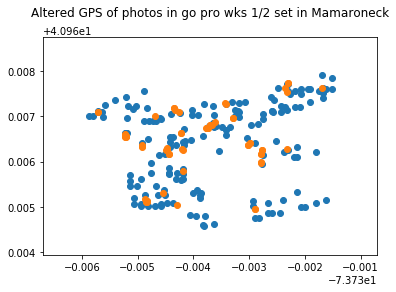

In [663]:
plt.figure(1)
plotgps(pd1,col1='new_lat',col2='new_lon')
plotgps(test,col1='obj_lat',col2='obj_lon')

## COMPARE VALIDATE ANNOTATED VS. FOUND

In [775]:
all_annos = pd.read_csv('/Users/elizabeth/Downloads/allbboxes.csv',index_col=[0,1,6])
#all_annos

In [776]:
#chooses only the items in the val_keys set
valid_annos = all_annos[all_annos['valid']]


In [789]:
#removing .jpgs from the photo names
#pd1.to_csv('~/Downloads/hackthesystem.csv')
new_pd1 = pd.read_csv('~/Downloads/hackthesystem.csv',index_col=[0])
all_objs = all_annos.join(new_pd1,how='inner')
len(all_objs)

288

In [790]:
#converts cooords in valid_annos into GPS locations
valid_annos = all_objs[all_objs['valid']]


In [798]:
all_objs_gs = px2gps(all_objs)
valid_objs_gps = px2gps(valid_annos)

## Plots

In [871]:
print(plt.style.available)
plt.style.use('seaborn')

[u'seaborn-darkgrid', u'Solarize_Light2', u'seaborn-notebook', u'classic', u'seaborn-ticks', u'grayscale', u'bmh', u'seaborn-talk', u'dark_background', u'ggplot', u'fivethirtyeight', u'_classic_test', u'seaborn-colorblind', u'seaborn-deep', u'seaborn-whitegrid', u'seaborn-bright', u'seaborn-poster', u'seaborn-muted', u'seaborn-paper', u'seaborn-white', u'fast', u'seaborn-pastel', u'seaborn-dark', u'seaborn', u'seaborn-dark-palette']


In [881]:
col1='new_lat'
col2='new_lon'
print(new_pd1[col2].min()-.0005,new_pd1[col2].max()+.0005)
print(new_pd1[col1].min()-.0005, new_pd1[col1].max()+.0005)


(-73.736369179999997, -73.731005530000004)
(40.964088910000001, 40.968400080000002)


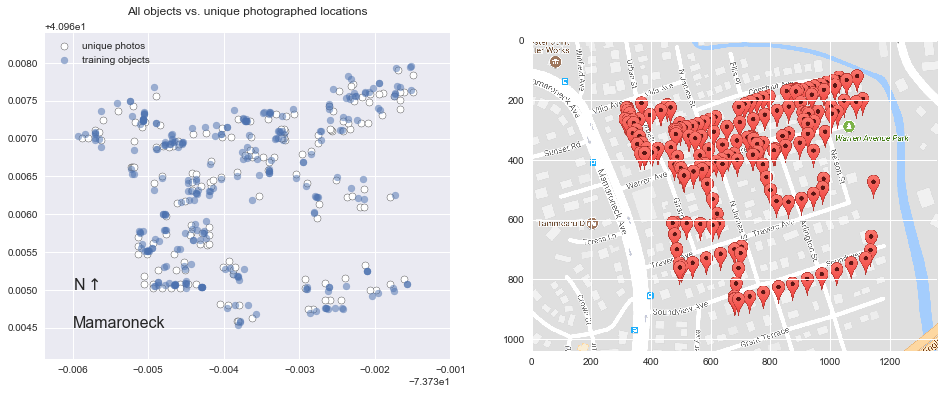

In [887]:
#all objects vs. unique photos

plt.figure(1,figsize = (16,6))
plt.subplot(1,2,1)

col1='new_lat'
col2='new_lon'
plt.scatter(new_pd1[col2],new_pd1[col1],facecolor='white',edgecolors='black')

plt.xlim(new_pd1[col2].min()-.0005, new_pd1[col2].max()+.0005)
plt.ylim(new_pd1[col1].min()-.0005, new_pd1[col1].max()+.0005)

col1='obj_lat'
col2='obj_lon'
plt.scatter(all_objs_gs[col2],all_objs_gs[col1],alpha=.5)

plt.legend(labels=['unique photos','training objects'])
plt.gca().invert_xaxis

plt.text(-73.736, 40.965,r'N$\uparrow$',fontsize=16)
plt.text(-73.736, 40.9645,r'Mamaroneck',fontsize=16)
plt.title('All objects vs. unique photographed locations\n')

plt.subplot(1,2,2)
mm = plt.imread('/Users/elizabeth/Desktop/Mamaroneck.png')
plt.imshow(mm)

Text(0.5,1,u'Validation objects vs. NN ID\n')

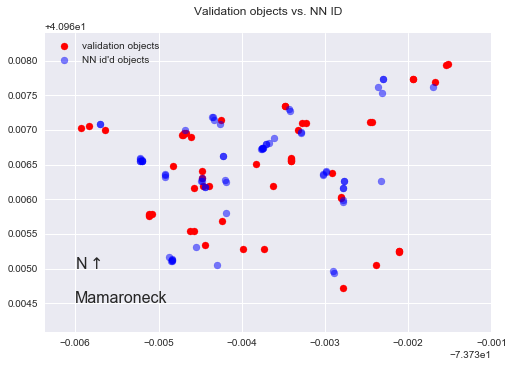

In [885]:
#all objects vs. unique photos

plt.figure(1)

col1='obj_lat'
col2='obj_lon'

plt.scatter(valid_objs_gps[col2],valid_objs_gps[col1],facecolor='red')

plt.xlim(-73.736369179999997, -73.731005530000004)
plt.ylim(40.964088910000001, 40.968400080000002)

plt.scatter(headings_w_nn[col2],headings_w_nn[col1],alpha=.5,facecolor='blue')

plt.legend(labels=['validation objects','NN id\'d objects'])
plt.gca().invert_xaxis

plt.text(-73.736, 40.965,r'N$\uparrow$',fontsize=16)
plt.text(-73.736, 40.9645,r'Mamaroneck',fontsize=16)
plt.title('Validation objects vs. NN ID\n')


In [888]:
print(len(valid_objs_gps), len(headings_w_nn))


(52, 68)


## CHANGE LAT/LON IN EXIF

In [157]:
path_to_open = '/Users/elizabeth/Box Sync/deeplearningcourse/elizabeth/data/harrison_fieldwork1/images_wks1_2/testingexif/'
path_to_save = '/Users/elizabeth/Box Sync/deeplearningcourse/elizabeth/data/harrison_fieldwork1/images_wks1_2/testingexif/'
img = 'G0036562_4.JPG'

f = open(path_to_open+img, 'rb')

# Return Exif tags
exif_dict = piexif.load

#convert to decimal
lat = tags['GPS GPSLatitude'].values
lon = tags['GPS GPSLongitude'].values

lat = [float(i.num/i.den) for i in lat]
lon = [float(i.num/i.den) for i in lon]

lat = lat[0] + (lat[1])/60 + lat[2]/3600
lon = lon[0] + (lon[1])/60 + lon[2]/3600

#splices crop slice number from file name
c = int(re.sub("[^0-9]","",img[-6:]))

#longitude
#for i in range(stepw)

if c==stepw*0 | c==stepw*1 | c==stepw*2 | c==stepw*3:# | stepw*4 | stepw*5:
    new_lon = lon - (stepw/2-0.5)*del_lon
    print('new lon=',new_lon)

elif c==(stepw*0+1) | c==stepw*1+1 | c==stepw*2+1 | c==stepw*3+1:#| stepw*4+1 | stepw*5+1:
    new_lon = lon - (stepw/2-1.5)*del_lon
    print('new lon=',new_lon)
    
elif c==stepw*0+2 | c==stepw*1+2 | c==stepw*2+2 | c==stepw*3+2:
    new_lon = lon - (stepw/2-2.5)*del_lon
    print('new lon=',new_lon)
    
elif c in [stepw*0+3,stepw*1+3,stepw*2+3,c==stepw*3+3]:
    new_lon = lon + (stepw/2-2.5)*del_lon
    print('new lon=',new_lon)
    
elif c in [stepw*0+4,stepw*1+4,stepw*2+4,c==stepw*3+4]:
    new_lon = lon + (stepw/2-1.5)*del_lon
    print('new lon=',new_lon)
    
elif c in [stepw*0+5,stepw*1+5,stepw*2+5,c==stepw*3+5]:
    new_lon = lon + (stepw/2-.5)*del_lon
    print('new lon=',new_lon)
    
else:
    print('lon num not defined', c)
    new_lon=lon

#latitude
if c in range(0,1*stepw):
    new_lat = lat + (steph/2-0.5)*lat_step
    print('new lat=',new_lat)
    
elif c in range(1*stepw,2*stepw):
    new_lat = lat + (steph/2-1.5)*lat_step
    print('new lat=',new_lat)
    
elif c in range(2*stepw,3*stepw):
    new_lat = lat + (steph/2-1.5)*lat_step
    print('new lat=',new_lat)
    
elif c in range(3*stepw,4*stepw):
    new_lat = lat + (steph/2-0.5)*lat_step
    print('new lat=',new_lat)
    
else:
    print('lat num not defined', c)
    new_lat=lat

print('new_lat = ', new_lat, "old lat =", lat)
print('new_lon = ',new_lon, "old lon =", lon)

('new lon=', 73.734519917327106)
('new lat=', 40.9670199173271)
('new_lat = ', 40.9670199173271, 'old lat =', 40.966944444444444)
('new_lon = ', 73.734519917327106, 'old lon =', 73.73444444444445)


In [128]:
px500 = 5.6 #m

lat_step = 5.6*lat_per_m # whatever step sizes you're taking (250px to centerline since photos are 500x500)
lon_step = 5.6*lon_per_m

#heading -- 0 for north, 90 if photo is turned east, etc; heading from north
theta = 0

#rotaion matrix [x';y'] = [cos -sin; sin cos][x;y]
del_lon= lat_step*np.cos(theta) - lon_step*np.sin(theta) 
del_lat = lat_step*np.sin(theta) +lon_step*np.cos(theta)

w = 3000
h = 2000
crop = 500

stepw = len(range(0,w,crop))
steph = len(range(0,h,crop))

def change_GPS_exif(dict_of_files,path_to_open,path_to_save)
      
    photo_info = {key:[0,0,0] for key in pd.keys()} #lat, lon

    files = [key for key in dict_of_files.keys()]

    for j in files :

        f = open(path_to_open+j, 'rb')

        # Return Exif tags
        exif_dict = piexif.load

        lat = dms2dec(tags['GPS GPSLatitude'].values)
        lon = dms2dec(tags['GPS GPSLongitude'].values)
        
        #longitude
        if c==stepw*0 | c==stepw*1 | c==stepw*2 | c==stepw*3:# | stepw*4 | stepw*5:
            new_lon = lon - (stepw/2-0.5)*del_lon

        elif c==stepw*0+1 | c==stepw*1+1 | c==stepw*2+1 | c==stepw*3+1:#| stepw*4+1 | stepw*5+1:
            new_lon = lon - (stepw/2-1.5)*del_lon

        elif c==stepw*0+2 | c==stepw*1+2 | c==stepw*2+2 | c==stepw*3+2:
            new_lon = lon - (stepw/2-2.5)*del_lon

        elif c==stepw*0+3 | c==stepw*1+3 | c==stepw*2+3 | c==stepw*3+3:
            new_lon = lon + (stepw/2-2.5)*del_lon

        elif c==stepw*0+4 | c==stepw*1+4 | c==stepw*2+4 | c==stepw*3+4:
            new_lon = lon + (stepw/2-1.5)*del_lon

        elif c==stepw*0+5 | c==stepw*1+5 | c==stepw*2+5 | c==stepw*3+5:
            new_lon = lon + (stepw/2-.5)*del_lon
        else:
            print('lon num not defined')
            new_lon=lon
        
        #latitude
        if c in range(0,1*stepw):
            new_lat = lat + (steph/2-0.5)*lat_step
        elif c in range(1*stepw,2*stepw):
            new_lat = lat + (steph/2-1.5)*lat_step
        elif c in range(2*stepw,3*stepw):
            new_lat = lat + (steph/2-1.5)*lat_step
        elif c in range(3*stepw,4*stepw):
            new_lat = lat + (steph/2-0.5)*lat_step
        else:
            print('lat num not defined' )
            new_lat=lat
        
        exif_dict['GPS'][2] = new_lat
        exif_dict['GPS'][4] = new_lon
        
        exif_bytes = piexif.dump(exifdict)
        im = Image.open(f)
        im.save(path_to_save+f, exif=exif_bytes)
        
        return lat,lon,new_lat,new_lon 
    

SyntaxError: invalid syntax (<ipython-input-128-1a373f807d39>, line 23)

In [733]:
bounding_boxes = {}
image_name = 'test'
class_name = 'box'
n = 5
ymin = 2
xmin = 3
bounding_box = [class_name,n,xmin,ymin]
bounding_boxes[image_name]=bounding_box
bounding_boxes['test'][1]

5

In [735]:
filenames = [1,2,3,4]
bounding_boxes = pd.DataFrame(index=filenames)

In [736]:
bounding_boxes.loc

""
1
2
3
4
